Loading preprocessed datasets...
Data shapes:
  X_train: (1240596, 40), y_train: (1240596,)
   X_test: (311614, 40), y_test: (311614,)

Target distribution:
  Train: {0: 1218233, 1: 22363}
  Test : {0: 306061, 1: 5553}
Class imbalance ratio (neg/pos): 54.48

Starting randomized hyperparameter tuning…
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=200, scale_pos_weight=140, subsample=1.0; total time=  20.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=200, scale_pos_weight=140, subsample=1.0; total time=  21.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=200, scale_pos_weight=140, subsample=1.0; total time=  21.2s
[CV] END colsample_bytree=0.9, learning_rate=0.12, max_depth=6, min_child_weight=5, n_estimators=350, scale_pos_weight=80, subsample=0.8; total time=  26.6s
[CV] END 

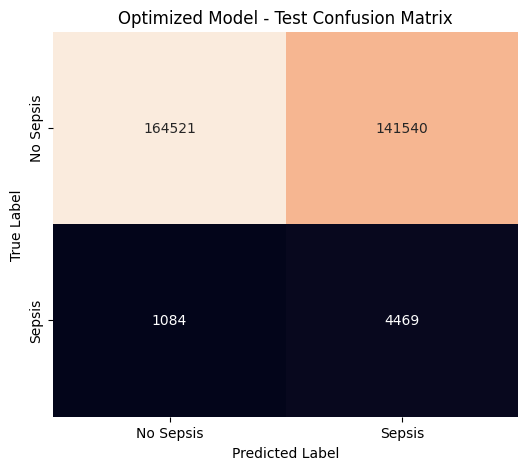

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score as recall_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

print("Loading preprocessed datasets...")

# ————— Only train & test now —————
train_df = pd.read_csv('/teamspace/studios/this_studio/physionet_train.csv')
test_df  = pd.read_csv('/teamspace/studios/this_studio/physionet_test.csv')
# ————————————————————————————————

# Identify your target column (second‐to‐last)
target_col = train_df.columns[-2]

# 1) Prepare X/y, dropping PatientID and target
X_train = train_df.drop([target_col, 'PatientID'], axis=1)
y_train = train_df[target_col]

X_test  = test_df.drop ([target_col, 'PatientID'], axis=1)
y_test  = test_df[target_col]

print(f"Data shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nTarget distribution:")
print(f"  Train: {y_train.value_counts().to_dict()}")
print(f"  Test : {y_test.value_counts().to_dict()}")

# 2) Compute class imbalance ratio for scale_pos_weight
class_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Class imbalance ratio (neg/pos): {class_ratio:.2f}")

# 3) Randomized hyperparameter tuning (optimize recall)
param_dist = {
    'scale_pos_weight': np.arange(60, 201, 20),
    'max_depth':        [6, 8, 10, 12],
    'learning_rate':    [0.05, 0.08, 0.1, 0.12, 0.15],
    'n_estimators':     [200, 250, 300, 350, 400],
    'min_child_weight': [1, 2, 3, 5],
    'subsample':        [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]  #The fraction of features to randomly sample for each tree.
}

base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring=make_scorer(recall_scorer),
    cv=3,
    n_jobs=1,
    verbose=2,
    random_state=42
)

print("\nStarting randomized hyperparameter tuning…")
random_search.fit(X_train, y_train)

print("\nTuning complete!")
print(f"Best recall (CV): {random_search.best_score_:.4f}")
print(f"Best params     : {random_search.best_params_}")

# 4) Train final model with best params
best_params = random_search.best_params_
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    **best_params
)

print("\nTraining final model on full train set…")
final_model.fit(X_train, y_train)
print("Training complete!")

# 5) Evaluate on test set
y_pred = final_model.predict(X_test)

acc  = accuracy_score(y_test,  y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test,    y_pred, zero_division=0)
f1   = f1_score(y_test,        y_pred, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("\n=== TEST SET METRICS ===")
print(f"Accuracy        : {acc:.4f}")
print(f"Precision       : {prec:.4f}")
print(f"Recall          : {rec:.4f}")
print(f"F1 Score        : {f1:.4f}")
print(f"False Negatives : {fn}")

# 6) Confusion matrix plot
cm = np.array([[tn, fp],
               [fn, tp]])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['No Sepsis','Sepsis'],
            yticklabels=['No Sepsis','Sepsis'])
plt.title('Optimized Model - Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
